### Task 3 With Cirq

Now we will solve the same proble, this time quantumly. To do this I will rewrite the juilia code that was used in the complete Task 2. The first thing that we will need to do is write the functions that will get the edges as well as the
Ω(t) and δ(t) functions from the equation. 

In [79]:
import numpy as np
import scipy as sc
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import networkx as nx
from abstract_udmis import AbstractUDMIS
import openfermion as of
import qiskit as qis

%matplotlib inline

In [80]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

In [115]:
u = 1.35
Ω_max = 1.89
δ_0 = -1.0
δ_max = 1.0
dt = 0.001
SampleSize = 20000
graph = [
    (1.19, 4.25),
    (2.71, 3.48),
    (1.19, 3.51),
    (2.0, 3.38),
    (1.12, 2.86),
    (1.70, 2.42),
    (2.36, 2.54),
    (1.52, 1.48),
    (2.15, 1.54),
    (2.14, 1.87),
    (1.72, 0.86),
    (2.29, 0.87)
]

def findall(edges,Nv):
    result = []
    for i in range(Nv):
        for j in range(Nv):
            if edges[i][j]:
                result.append([i,j])
    return result

def get_edges(graph):
    Nv = len(graph)
    edges = [([0]*Nv) for i in range(Nv)]
    for i in range(Nv-1):
        xi, yi = graph[i]
        for j in range(i+1,Nv):
            xj,yj = graph[j]
            
            dij = np.sqrt((xi-xj)**2. + (yi-yj)**2.)
            if dij <= 1.0:
                edges[i][j] = True
    return findall(edges,Nv)

def Ω(t):
    if 0<=t and t<=0.25:
        return (Ω_max / 0.25) * t
    elif 0.25< t and t<=0.69:
        return Ω_max
    elif 0.69 < t and t<=1:
        return - Ω_max * t / 0.31 + Ω_max * (1 + 0.69/0.31)
    
def δ(t):
    slope = (δ_0 - δ_max)/(0.25 - 0.69)
    if 0<=t and t<=0.25:
         return δ_0
    elif 0.25< t and t<=0.69:
        return t * slope + (δ_max - slope * 0.69)
    elif 0.69 < t and t<=1:
        return δ_max   

edges= get_edges(graph)

In [116]:
'''
For some reason this was not being imported properly so I copied the code from the cirq repo found 
https://github.com/quantumlib/Cirq/blob/v0.11.0/cirq-core/cirq/vis/state_histogram.py
'''
from typing import Union, Optional, Sequence, SupportsFloat
import collections
import numpy as np
import matplotlib.pyplot as plt
from cirq.study.result import Result

def get_state_histogram(result: 'result.Result') -> np.ndarray:
    """Computes a state histogram from a single result with repetitions.
    Args:
        result: The trial result containing measurement results from which the
                state histogram should be computed.
    Returns:
        The state histogram (a numpy array) corresponding to the trial result.
    """
    num_qubits = sum([value.shape[1] for value in result.measurements.values()])
    states = 2 ** num_qubits
    values = np.zeros(states)
    # measurements is a dict of {measurement gate key:
    #                            array(repetitions, boolean result)}
    # Convert this to an array of repetitions, each with an array of booleans.
    # e.g. {q1: array([[True, True]]), q2: array([[False, False]])}
    #      --> array([[True, False], [True, False]])
    measurement_by_result = np.hstack(list(result.measurements.values()))

    for meas in measurement_by_result:
        # Convert each array of booleans to a string representation.
        # e.g. [True, False] -> [1, 0] -> '10' -> 2
        state_ind = int(''.join([str(x) for x in [int(x) for x in meas]]), 2)
        values[state_ind] += 1
    return values

def plot_state_histogram(
    data: Union['result.Result', collections.Counter, Sequence[SupportsFloat]],
    ax: Optional['plt.Axis'] = None,
    *,
    tick_label: Optional[Sequence[str]] = None,
    xlabel: Optional[str] = 'qubit state',
    ylabel: Optional[str] = 'result count',
    title: Optional[str] = 'Result State Histogram',
) -> 'plt.Axis':
    """Plot the state histogram from either a single result with repetitions or
       a histogram computed using `result.histogram()` or a flattened histogram
       of measurement results computed using `get_state_histogram`.
    Args:
        data:   The histogram values to plot. Possible options are:
                `result.Result`: Histogram is computed using
                    `get_state_histogram` and all 2 ** num_qubits values are
                    plotted, including 0s.
                `collections.Counter`: Only (key, value) pairs present in
                    collection are plotted.
                `Sequence[SupportsFloat]`: Values in the input sequence are
                    plotted. i'th entry corresponds to height of the i'th
                    bar in histogram.
        ax:      The Axes to plot on. If not given, a new figure is created,
                 plotted on, and shown.
        tick_label: Tick labels for the histogram plot in case input is not
                    `collections.Counter`. By default, label for i'th entry
                     is |i>.
        xlabel:  Label for the x-axis.
        ylabel:  Label for the y-axis.
        title:   Title of the plot.
    Returns:
        The axis that was plotted on.
    """
    show_fig = not ax
    if not ax:
        fig, ax = plt.subplots(1, 1)
    if isinstance(data, Result):
        values = get_state_histogram(data)
    elif isinstance(data, collections.Counter):
        tick_label, values = zip(*sorted(data.items()))
    else:
        values = data
    if not tick_label:
        tick_label = np.arange(len(values))
    ax.bar(np.arange(len(values)), values, tick_label=tick_label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if show_fig:
        fig.show()
    return ax


### Quantum Circuit 

From the instructions we know that the hamiltoninan for this particular system can be written as $H(t) = Ω(t)\sum_{i \in V}σ_i^x -δ(t)\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j$. 
While the time evolution operator take the form of $U(t) = $ and the circuit is juat a combination of this time evolution operator on the initial state.

In [146]:
'''
The fisrt part of this is to build the hamiltonian. The hamiltonian for this circuit can be wittern as 
H(t) = Ω(t) ∑_i σ_i^x - δ(t) ∑_i n_i + u ∑_ij n_i n_j 
'''
def nn(q1,q2,u):
    m = []
    m.append(cirq.ops.CNOT(q1,q2))
    m.append(cirq.ops.ZPowGate(global_shift=(dt*u)/(sc.constants.h*np.pi)).on(q2))
    m.append(cirq.ops.CNOT(q1,q2))
    return m
    
def hamiltonian(graph,edges,t,qubits):
    Nv=len(graph)
    circuit = cirq.Circuit([])
    # 1. Ω(t) ∑_i σ_i^x
    circuit.append(cirq.rx((2*Ω(t)*dt)/sc.constants.h).on(qubits[i])for i in range(Nv))
    
    # 2. - δ(t) ∑_i n_i
    # remeber for this P1 = 0.5*(I - sigma_z) so this can be writen as a linear combination of gates
    circuit.append(
        cirq.ops.ZPowGate(global_shift=(dt*δ(t))/(sc.constants.h*np.pi)).on(qubits[i])for i in range(Nv)
    )
    # 3. u ∑_ij n_i n_j 
    circuit.append(
        #cirq.ops.ZZPowGate(global_shift=(dt*u)/(sc.constants.h*np.pi)).on(qubits[edges[i][0]],qubits[edges[i][1]])
        #for i in range(len(edges))
        nn(qubits[edges[i][0]],qubits[edges[i][1]],u) for i in range(len(edges))
    )
    
    return circuit
        

def run_annealing(graph,edges,dt,SampleSize):
    Nv=len(graph)
    qubits = cirq.LineQubit.range(Nv)
    psi_t = cirq.Circuit([cirq.H(q) for q in qubits])
    for t in range(0,100,int(100/dt)):
        h = hamiltonian(graph, edges, t,qubits)
        psi_t.append(h) 
    psi_t.append([cirq.measure(q,key=f'q{count}') for count,q in enumerate(qubits)])
    result = cirq.Simulator().run(psi_t, repetitions=SampleSize)
    prob_df=result.data.groupby(result.data.columns.tolist(),as_index=False).size()
    prob_df['Probabilities']=prob_df['size']/SampleSize
    return prob_df,result

In [147]:
Nv=len(graph)
qubits = cirq.LineQubit.range(Nv)
h = hamiltonian(graph, edges, 0.0001,qubits)
print(h)

                    ┌──┐       ┌──┐               ┌──┐       ┌──┐                                                   ┌──┐       ┌──┐                           ┌──┐       ┌──┐   ┌──┐       ┌──┐
0: ────Rx(2π)───Z────@──────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │          │
1: ────Rx(2π)───Z────┼@─────────┼@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     ││         ││
2: ────Rx(2π)───Z────X┼────Z────X┼────@───────@────@──────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                      │          │    │       │    │          │
3: ────Rx(2π)───Z─

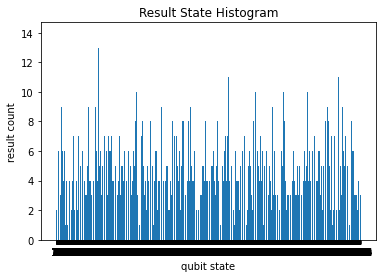

In [148]:
prod_df,_result = run_annealing(graph, edges, dt,SampleSize)
_ = plot_state_histogram(_result, plt.subplot())

In [149]:
prod_df
# print the row in the with the highest prob that will be our answer
answer = prod_df[prod_df.Probabilities == prod_df.Probabilities.max()]
print(answer)

     q0  q1  q2  q3  q4  q5  q6  q9  q7  q8  q10  q11  size  Probabilities
688   0   0   1   0   1   0   1   1   0   1    1    1    14         0.0007


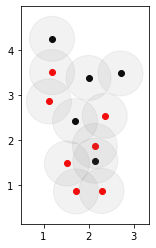

In [151]:
bstring = prod_df.loc[688 , :].values.flatten().tolist()[:-2]
fig, ax = plt.subplots()
for i,occ in enumerate(bstring):
    if occ==1.0:
        c = 'red' 
    else:
        c ='black'
    x,y = graph[i]
    
    circle = plt.Circle((x,y), 0.5, color='grey', alpha=0.1)
    ax.add_patch(circle)
    
    plt.scatter(x, y, color=c, marker='o')
    
plt.gca().set_aspect(1)

In [123]:
prod_df

,q0,q1,q2,q3,q4,q5,q6,q9,q7,q8,q10,q11,size,Probabilities
0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.00015
1,0,0,0,0,0,0,0,0,0,0,0,1,7,0.00035
2,0,0,0,0,0,0,0,0,0,0,1,0,7,0.00035
3,0,0,0,0,0,0,0,0,0,0,1,1,9,0.00045
4,0,0,0,0,0,0,0,0,0,1,0,0,5,0.00025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063,1,1,1,1,1,1,1,1,1,0,1,1,8,0.00040
4064,1,1,1,1,1,1,1,1,1,1,0,0,1,0.00005
4065,1,1,1,1,1,1,1,1,1,1,0,1,4,0.00020
4066,1,1,1,1,1,1,1,1,1,1,1,0,2,0.00010
